In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [ ]:
def load_data(images_path, masks_path, img_height, img_width):
    images = sorted(glob(os.path.join(images_path, "*.jpg")))
    masks = sorted(glob(os.path.join(masks_path, "*.png")))

    all_images = []
    all_masks = []

    for img, mask in zip(images, masks):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0
        all_images.append(img)

        mask = cv2.imread(mask, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (img_width, img_height))
        #mask = mask / 255.0
        all_masks.append(mask)

    return (np.array(all_images), np.array(all_masks))

In [ ]:
def mask_to_onehot(mask, color_map):
    one_hot = np.zeros((*mask.shape[:2], len(color_map)), dtype=np.uint8)

    for class_idx, color in enumerate(color_map.values()):
        one_hot[np.where(np.all(mask == color, axis=-1))] = np.eye(len(color_map), dtype=np.uint8)[class_idx]

    return one_hot

In [ ]:
color_map = {
    0: (0, 0, 0),    # Background
    1: (0, 0, 128),  # LowerBack-Right
    2: (0, 128, 0),  # LowerBack-Left
    3: (0, 128, 64), # Neck-Left
    4: (128, 0, 128), # Neck-Right
    5: (128, 0, 0), # UpperBack-Left
    6: (0, 128, 128), # UpperBack-Right
    7: (128, 128, 128), # Spinal Cord
}

In [ ]:
folder_a = "/content/drive/MyDrive/Dataset_Segmentation/A"
folder_b = "/content/drive/MyDrive/Dataset_Segmentation/Overlays_new2"
img_height = 256
img_width = 256

images, masks = load_data(folder_a, folder_b, img_height, img_width)
#onehot_masks = np.array([mask_to_onehot(m, color_map) for m in masks])

In [ ]:
onehot_masks = np.array([mask_to_onehot(m, color_map) for m in masks])

In [ ]:
masks.shape

(55, 256, 256, 3)

In [ ]:
masks[6,100,97]

array([  0, 128,  64], dtype=uint8)

In [ ]:
images.shape

(55, 256, 256, 3)

In [ ]:
onehot_masks.shape

(55, 256, 256, 8)

In [ ]:
onehot_masks[8,200,108]

array([0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, onehot_masks, test_size=0.2, random_state=42)

In [ ]:
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
batch_size = 16

image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

train_generator = zip(image_generator, mask_generator)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (44, 256, 256, 8) (8 channels).
  warnings.warn(


In [ ]:
train_generator

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Activation, Concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose
from keras.models import Model

# The Convolution Block

def conv_block(input, num_filters):

  x = Conv2D(num_filters, kernel_size=(3,3), padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, kernel_size=(3,3), padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

# The Encoder Block

def encoder_block(input, num_filters):

  x = conv_block (input, num_filters)
  p = MaxPool2D ((2,2))(x)

  return x , p

# The Decoder Block

def decoder_block(input, skip_features, num_filters):

  x = Conv2DTranspose(num_filters, kernel_size=(2,2), strides=2, padding="same")(input)
  x = Concatenate()([x , skip_features])
  x = conv_block(x, num_filters)

  return x

# Building a U-net Model

def u_net(input_shape, classes):

  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(classes, 1, padding="same", activation='softmax')(d4)

  model = Model(inputs, outputs, name="U-Net")

  return model


In [ ]:
model = u_net(input_shape=(256,256,3), classes=8)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
     batch_size = batch_size,
    steps_per_epoch=150,
    epochs=20
)

Epoch 1/20
150/150 [==============================] - 188s 1s/step - loss: 0.6827 - accuracy: 0.7677
Epoch 2/20
150/150 [==============================] - 144s 957ms/step - loss: 0.2776 - accuracy: 0.8954
Epoch 3/20
150/150 [==============================] - 142s 948ms/step - loss: 0.1685 - accuracy: 0.9341
Epoch 4/20
150/150 [==============================] - 141s 941ms/step - loss: 0.1325 - accuracy: 0.9489
Epoch 5/20
150/150 [==============================] - 141s 939ms/step - loss: 0.1463 - accuracy: 0.9452
Epoch 6/20
150/150 [==============================] - 141s 936ms/step - loss: 0.1488 - accuracy: 0.9454
Epoch 7/20
150/150 [==============================] - 141s 940ms/step - loss: 0.1593 - accuracy: 0.9416
Epoch 8/20
150/150 [==============================] - 143s 949ms/step - loss: 0.1364 - accuracy: 0.9495
Epoch 9/20
150/150 [==============================] - 143s 955ms/step - loss: 0.1253 - accuracy: 0.9541
Epoch 10/20
150/150 [==============================] - 143s 955ms/s

1/1 [==============================] - 6s 6s/step


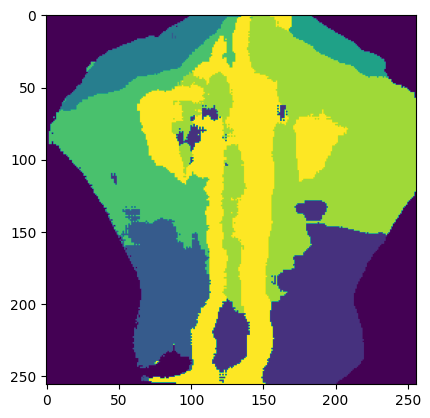

In [ ]:
    #test_image = x_val
    predicted_mask = model.predict(x_val)
    segmented_image = np.argmax(predicted_mask, axis=-1)

    # Visualize the result
    #plt.imshow(test_image[0])
    plt.imshow(segmented_image[2])
    #plt.show()

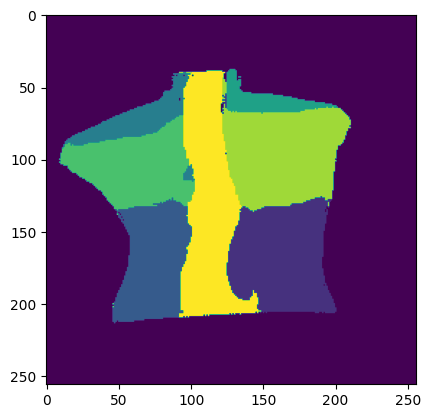

In [ ]:
plt.imshow(segmented_image[0])

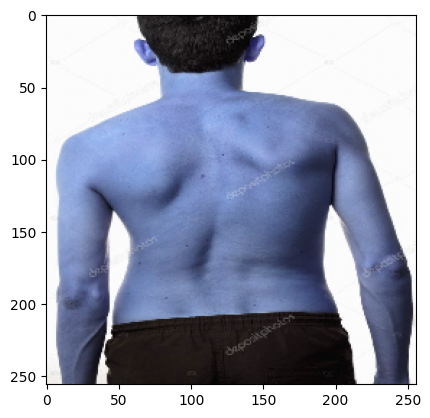

In [ ]:
plt.imshow(x_val[0])

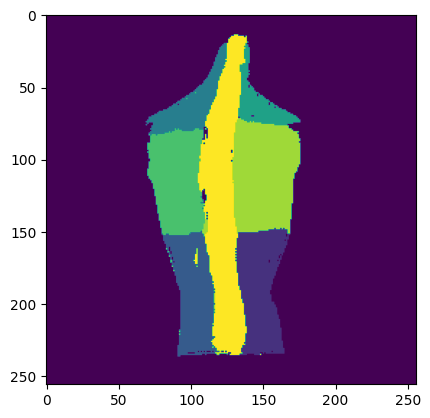

In [ ]:
plt.imshow(segmented_image[3])

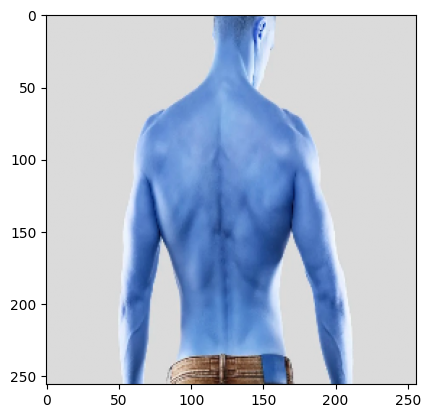

In [ ]:
plt.imshow(x_val[3])

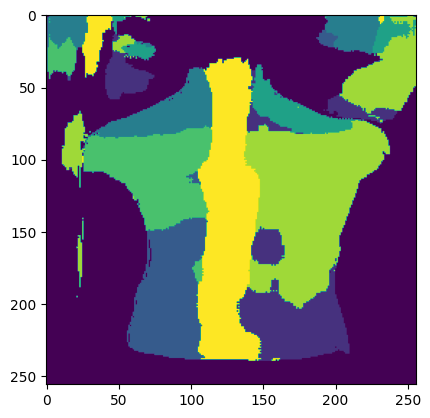

In [ ]:
plt.imshow(segmented_image[4])

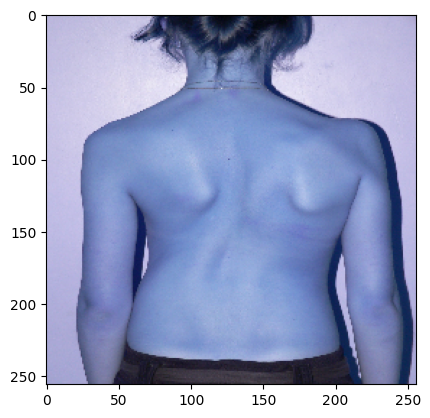

In [ ]:
plt.imshow(x_val[4])

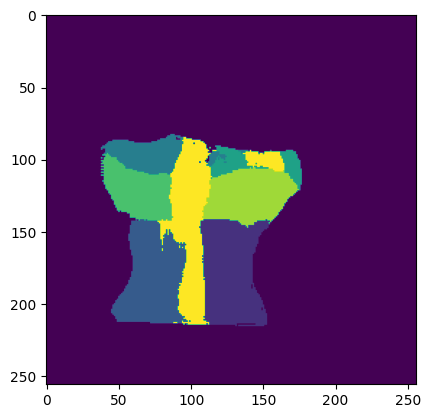

In [ ]:
plt.imshow(segmented_image[5])

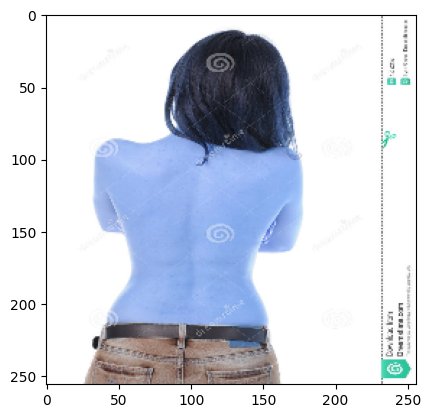

In [ ]:
plt.imshow(x_val[5])

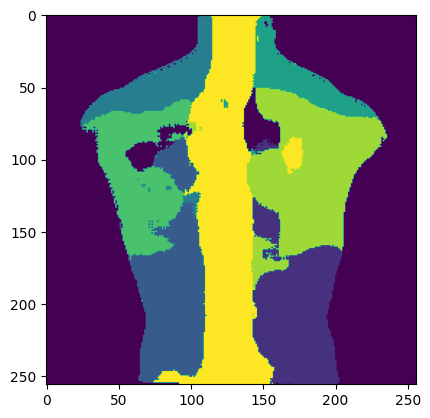

In [ ]:
plt.imshow(segmented_image[9])

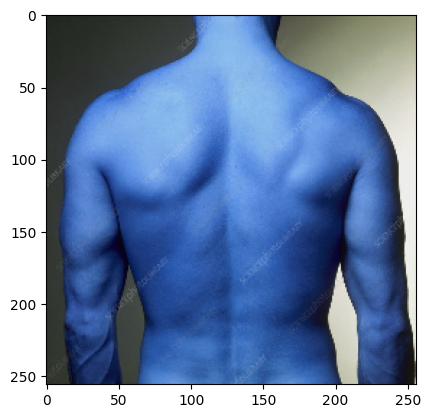

In [ ]:
plt.imshow(x_val[9])

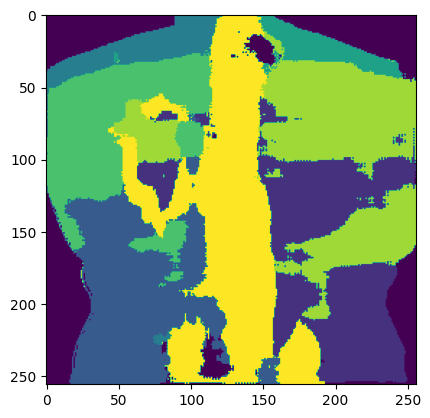

In [ ]:
plt.imshow(segmented_image[10])

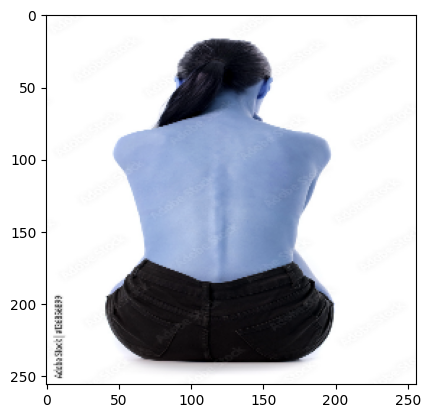

In [ ]:
plt.imshow(x_val[11])

In [ ]:
processed_onehot = np.argmax(y_val, axis=-1)


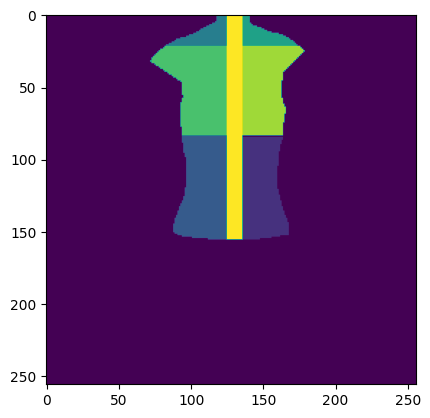

In [ ]:
plt.imshow(processed_onehot[8])

In [ ]:
x_val.shape

(12, 256, 256, 3)

In [ ]:
sample = model.predict(images)
processed_sample = np.argmax(sample, axis=-1)


2/2 [==============================] - 22s 10s/step


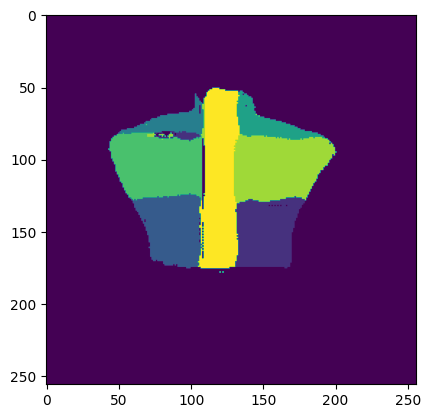

In [ ]:
k = 20
plt.imshow(images[k])
plt.imshow(processed_sample[k])
plt.show()

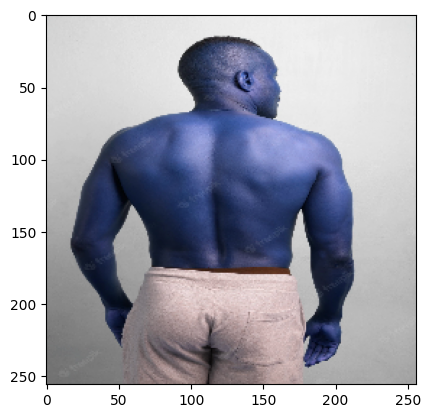

In [ ]:
plt.imshow(images[20])

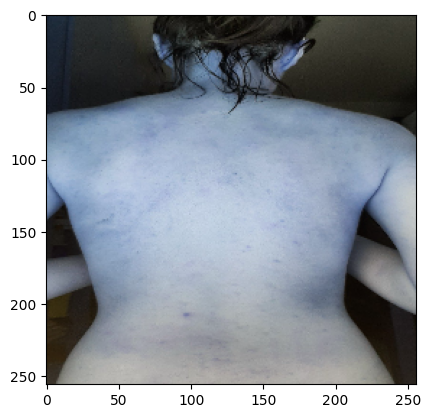

In [ ]:
plt.imshow(images[k])

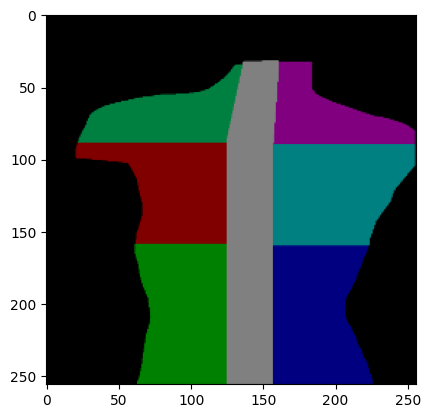

In [ ]:
plt.imshow(masks[k])

In [ ]:
onehot_masks[7,100,70]

array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

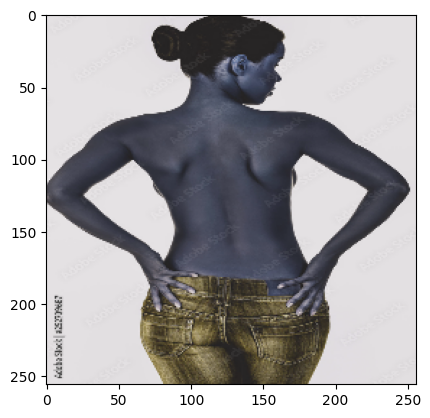

In [ ]:
plt.imshow(images[5])

In [ ]:
model.save('body_segmentation.h5')

In [ ]:
from google.colab import files
files.download('body_segmentation.h5')

In [ ]:
all_arman=[]

In [ ]:
arman = cv2.imread('/content/20230624_182413.jpg', cv2.IMREAD_COLOR)
arman = cv2.resize(arman, (img_width, img_height))
arman = arman / 255.0
all_arman.append(arman)

In [ ]:
all_arman = np.array(all_arman)

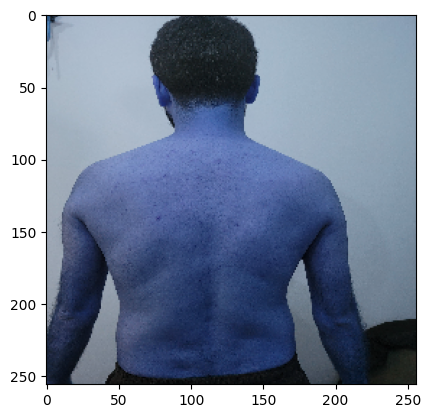

In [ ]:
plt.imshow(all_arman[0])

1/1 [==============================] - 0s 25ms/step


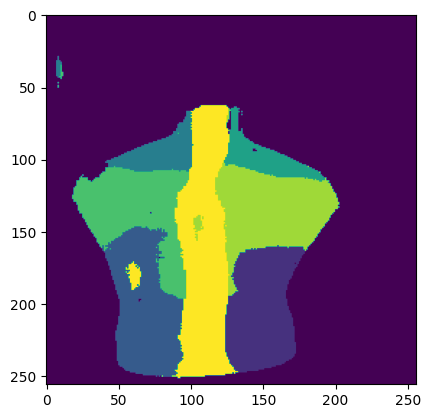

In [ ]:
predicted_arman = model.predict(all_arman)
arman_segmented = np.argmax(predicted_arman, axis=-1)
plt.imshow(arman_segmented[0])

In [ ]:
all_arman.shape

(2, 256, 256, 3)

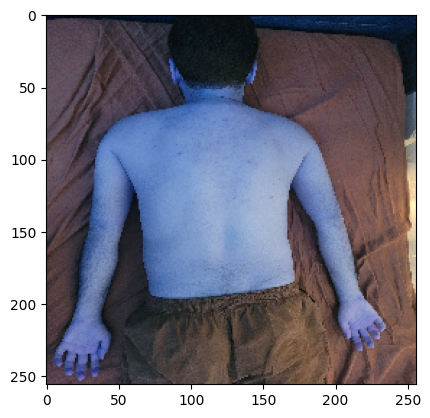

In [ ]:
plt.imshow(all_arman[1])

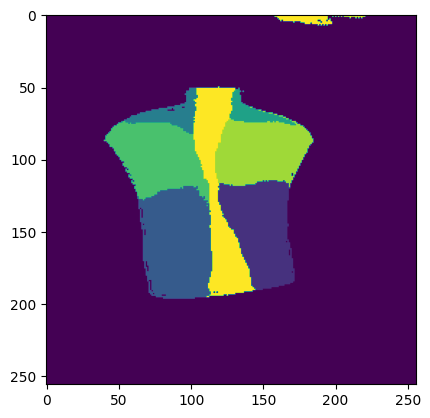

In [ ]:
plt.imshow(arman_segmented[1])